# Plot the ground track of a satellite

This is an example of an interactive use of the orekit python module, in a iPython notebook environment.

Example by Petrus Hyvönen, SSC, 2014

In [7]:
%matplotlib inline
#figsize(15,15)

## Setup Orekit

First we setup the orekit JCC bridge, and imports the objects to be used.

In [8]:
import orekit_jpype
vm = orekit_jpype.initVM()

In [43]:
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.frames import FramesFactory
from org.orekit.bodies import OneAxisEllipsoid
from org.orekit.time import TimeScalesFactory, AbsoluteDate
from org.orekit.orbits import KeplerianOrbit, PositionAngleType
from org.orekit.utils import Constants, IERSConventions
from org.orekit.propagation.analytical import EcksteinHechlerPropagator

from orekit_jpype.pyhelpers import setup_orekit_data, absolutedate_to_datetime

In [ ]:
from math import radians
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

The orekit library needs a data file with various information on time and earth rotation parameters. This file, called orekit-data.zip is loaded from current dir.

In [11]:
setup_orekit_data()

In [12]:
## Some Constants
ae = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
mu = Constants.WGS84_EARTH_MU
utc = TimeScalesFactory.getUTC()

In [13]:
## Osculating orbit
#Initial orbit parameters
ra = 800 * 1000         # Apogee
rp = 700 * 1000         # Perigee
i = radians(98.55)      # Inclination
omega = radians(90.0)   # Perigee argument
raan = radians(5.1917)  # Right ascension of ascending node
lv = radians(359.93)    # True anomaly

epochDate = AbsoluteDate(2012, 1, 26, 16, 0, 00.000, utc)

a = (rp + ra + 2 * ae) / 2.0    
e = 1.0 - (rp + ae) / a

## Inertial frame where the satellite is defined
inertialFrame = FramesFactory.getEME2000()

## Orbit construction as Keplerian
initialkeplerOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngleType.TRUE,
                              inertialFrame, epochDate, mu)

In [14]:
print(initialkeplerOrbit)

Keplerian parameters: {a: 7128137.0; e: 0.007014455530245822; i: 98.55; pa: 90.0; raan: 5.191699999999999; v: 359.93;}


In [15]:
print (initialkeplerOrbit.getKeplerianPeriod()/60, ' minutes per orbit')

99.82143003069034  minutes per orbit


In [16]:
print (24*60*60 / initialkeplerOrbit.getKeplerianPeriod(), ' orbits per day')

14.42576007533922  orbits per day


In [17]:
## Set up Propagator for reference orbit
eck_prop = EcksteinHechlerPropagator(initialkeplerOrbit,
                                    Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                    Constants.WGS84_EARTH_MU,
                                    Constants.WGS84_EARTH_C20,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.0)

Create the time vector

In [18]:
startDate = AbsoluteDate(2012, 1, 26, 11, 0, 00.000, utc)

# Overall duration in seconds for extrapolation
duration = 24 * 60 * 60
step_time = 10

# Time array in orekit AbsoluteDate format
t = [startDate.shiftedBy(float(dt)) \
        for dt in np.arange(0, duration, step_time)]

Create the satellite position vector

In [19]:
pv = [eck_prop.propagate(tt).getPVCoordinates() for tt in t]
p = [tpv.getPosition() for tpv in pv]

Create a planet to map positions on

In [20]:
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)

Calculate the geographical subpoints

Each subpoints requires a position from the p-vector and a time stamp from the t-vector

In [21]:
subpoint = [earth.transform(tp, inertialFrame, tt)  for tt, tp in zip(t,p)]

In [ ]:
lat = np.degrees([gp.getLatitude()  for gp in subpoint])
lon = np.degrees([gp.getLongitude() for gp in subpoint])


## Matplotlib Example

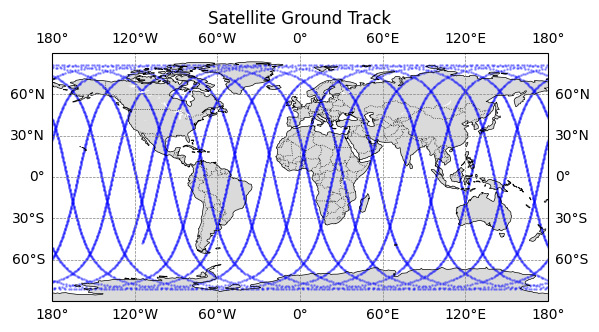

In [23]:
# Create a Cartopy map with cylindrical projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Add features to the map
ax.coastlines(resolution='110m', color='black', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='#dadada')
ax.add_feature(cfeature.LAKES, facecolor='white')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)

# Plot the satellite ground track
ax.scatter(lon, lat, alpha=0.3, color='blue', s=1, transform=ccrs.PlateCarree())

plt.title('Satellite Ground Track')
plt.show()

# Plotly Express example

In [44]:


# Create a DataFrame for the satellite ground track
data = pd.DataFrame({'Latitude': lat, 
                     'Longitude': lon,
                     'Timestamp': [absolutedate_to_datetime(x) for x in t]})


In [53]:

fig = px.scatter_geo(
    data,
    lat='Latitude',
    lon='Longitude',
    hover_name='Timestamp',
    title='Satellite Ground Track',
    projection='natural earth'
)

# Reduce the marker size
fig.update_traces(marker=dict(size=2))

# Customize the map
fig.update_geos(
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="rgb(229, 229, 229)",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="Blue",
    showrivers=True, rivercolor="Blue"
)

fig.show()